In [104]:
import tensorflow_datasets as tfds
dataset_name = "cats_vs_dogs"
cats_vs_dogs = tfds.builder(dataset_name)
cats_vs_dogs.info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/root/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul

In [105]:
cats_vs_dogs.download_and_prepare()

In [106]:
split = ['train[:70%]', 'train[70%:]']
(train_dataset, test_dataset), info= tfds.load(dataset_name, split=split, with_info=True, as_supervised=True) 
len(train_dataset), len(test_dataset)

(16283, 6979)

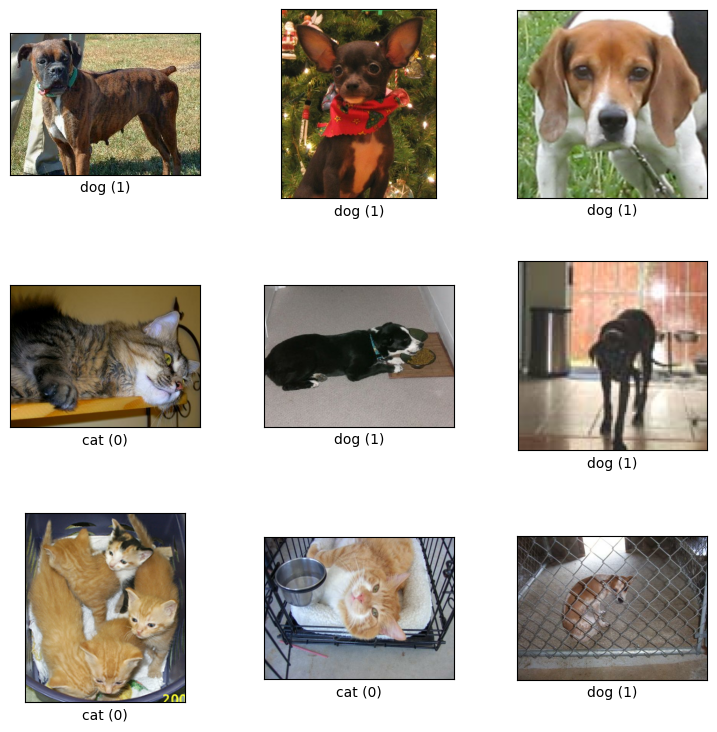

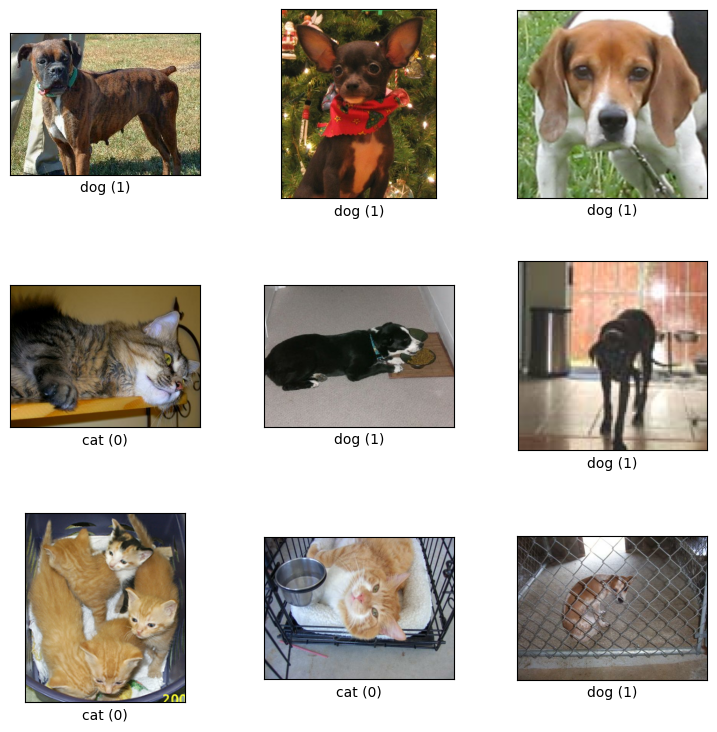

In [107]:
tfds.show_examples(train_dataset, info)

In [108]:
class_names = info.features['label'].names
num_classes = info.features['label'].num_classes
num_examples = info.splits['train'].num_examples
class_names, num_classes, num_examples

(['cat', 'dog'], 2, 23262)

In [109]:
train_one_sample = train_dataset.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [110]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (262, 350, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: 1
  Class name (str form): dog
        


In [111]:
image

<tf.Tensor: shape=(262, 350, 3), dtype=uint8, numpy=
array([[[242, 248, 248],
        [240, 246, 246],
        [235, 239, 238],
        ...,
        [188, 174, 127],
        [145, 133,  85],
        [161, 149, 101]],

       [[238, 244, 244],
        [239, 245, 245],
        [235, 239, 238],
        ...,
        [188, 176, 128],
        [165, 153, 105],
        [178, 168, 119]],

       [[237, 241, 240],
        [238, 242, 241],
        [232, 236, 235],
        ...,
        [200, 187, 142],
        [201, 191, 142],
        [200, 192, 143]],

       ...,

       [[130, 122,  75],
        [152, 146,  98],
        [154, 148,  98],
        ...,
        [161, 166, 136],
        [ 77,  86,  57],
        [ 71,  82,  52]],

       [[167, 159, 112],
        [105,  99,  51],
        [148, 142,  92],
        ...,
        [ 67,  73,  45],
        [ 46,  56,  29],
        [ 41,  54,  26]],

       [[138, 130,  83],
        [ 83,  77,  29],
        [135, 129,  79],
        ...,
        [ 68,  74,  4

In [112]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [113]:
def preprocess(image, label, image_shape=224):
  image = tf.image.resize(image, [image_shape, image_shape])
  image = tf.cast(image, tf.float32) / 255.
  return image, label
image, label = preprocess(image, label, 224)
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [114]:
train_dataset = train_dataset.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)


In [116]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [117]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False
for layer in base_model.layers[-10:]:
  layer.trainable=True

In [118]:
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f23a37fe110> False
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f238465afb0> False
2 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2384658b20> False
3 <keras.layers.activation.relu.ReLU object at 0x7f2384659720> False
4 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f238465a740> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f23852f3f70> False
6 <keras.layers.activation.relu.ReLU object at 0x7f2384659cf0> False
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f23852f0d90> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f23852f31f0> False
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f23852f08e0> False
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2385817d30> False
11 <keras.layers.activation.relu.ReLU object at 0x7f2385816320>

In [119]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

In [120]:
inputs = tf.keras.Input(shape=(224,224,3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1)(x)
outputs = tf.keras.layers.Activation("sigmoid", dtype=tf.float32, name="sigmoid_float32")(x) 
model = tf.keras.Model(inputs, outputs, name="MobileNetV2_fine_tuning")
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [121]:
model.summary()

Model: "MobileNetV2_fine_tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
 sigmoid_float32 (Activation  (None, 1)                0         
 )                                                               
                                           

In [122]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
mobilenetv2_1.00_224 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
sigmoid_float32 True float32 <Policy "float32">


In [123]:
history = model.fit(train_dataset,
               epochs=100, 
               steps_per_epoch=len(train_dataset),
               validation_data=test_dataset,
               validation_steps=len(test_dataset), 
               callbacks=[early_stopping, reduce_lr])

Epoch 1/100
509/509 [==============================] - 43s 77ms/step - loss: 0.1308 - accuracy: 0.9527 - val_loss: 0.0678 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - 39s 74ms/step - loss: 0.0779 - accuracy: 0.9720 - val_loss: 0.0562 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 3/100
509/509 [==============================] - 41s 78ms/step - loss: 0.0700 - accuracy: 0.9743 - val_loss: 0.0518 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 4/100
509/509 [==============================] - 39s 73ms/step - loss: 0.0667 - accuracy: 0.9764 - val_loss: 0.0455 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 5/100
509/509 [==============================] - 38s 73ms/step - loss: 0.0662 - accuracy: 0.9773 - val_loss: 0.0472 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 6/100
507/509 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9783
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
509/509 [===========================

1/1 [==============================] - 0s 61ms/step


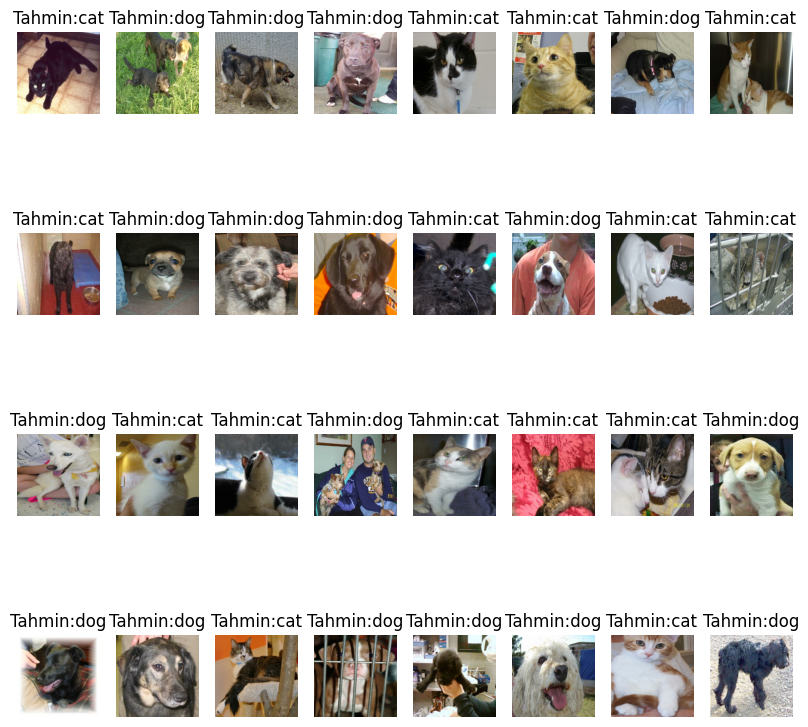

In [130]:
import matplotlib.pyplot as plt
for image, label in test_dataset.take(1):
  predictions = model.predict(image)

  fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 10))
  for i, ax in enumerate(axes.flat):
    ax.imshow(image[i].numpy())
    ax.axis("off")
    ax.set_title(f"Tahmin:{class_names[round(float(predictions[i][0]))]}")